In [2]:
# IMPORT LIBRARIES AND CONFIG

import os
# import datetime
from numpy import savez_compressed
from numpy import load

import IPython
import IPython.display

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.figure as mpfg
import mplfinance as mpf

from datetime import datetime, date
import calendar


physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
# tf.debugging.set_log_device_placement(True)


In [3]:
# GLOBAL VARIABLES

INPUT_SYMBOL = 'EURUSD'

LABEL_BASE_RATE = 0.0008

# IMAGE_LENGTH_M15 = 48
# IMAGE_LENGTH_H1 = 48
# IMAGE_LENGTH_H4 = 24
# IMAGE_LENGTH_M5 = 24
# IMAGE_LENGTH_D1 = 7

IMAGE_LENGTH_M15 = 24
IMAGE_LENGTH_H1 = 24
IMAGE_LENGTH_H4 = 12
IMAGE_LENGTH_M5 = 12
IMAGE_LENGTH_D1 = 10

GAP_M5 = 5 * 60
GAP_M15 = 15 * 60
GAP_H1 = 3600
GAP_H4 = GAP_H1 * 4
GAP_D1 = GAP_H1 * 24

TRAIN_RATE = 0.7

DAY = 2 * np.pi / (24*60*60)
WEEK = DAY / 7
YEAR = DAY / (365.2425)


MAX_BAR = 250000
MAX_LENGTH_X = int((MAX_BAR - IMAGE_LENGTH_M5) / 288)




In [3]:
# FETCH DATA FROM METATRADER AND SAVE TO FILE

from datetime import datetime
import MetaTrader5 as mt5
import numpy as np
from numpy import savez_compressed

DAY_HISTORY = 860
INPUT_STARTDATE = datetime(2020, 10, 15, 19)
INPUT_SYMBOL = 'EURUSD'


#     M15    H1     H4     M5     D1
# ----50-----50-----20-----20-----10

mt5.initialize()

m5 = mt5.copy_rates_from(INPUT_SYMBOL, mt5.TIMEFRAME_M5, INPUT_STARTDATE, DAY_HISTORY * 288 + IMAGE_LENGTH_M5)
err_m5 = mt5.last_error()
h4 = mt5.copy_rates_from(INPUT_SYMBOL, mt5.TIMEFRAME_H4, INPUT_STARTDATE, DAY_HISTORY * 6 + IMAGE_LENGTH_H4)
err_h4 = mt5.last_error()
m15 = mt5.copy_rates_from(INPUT_SYMBOL, mt5.TIMEFRAME_M15, INPUT_STARTDATE, DAY_HISTORY * 96 + IMAGE_LENGTH_M15)
err_m15 = mt5.last_error()
h1 = mt5.copy_rates_from(INPUT_SYMBOL, mt5.TIMEFRAME_H1, INPUT_STARTDATE, DAY_HISTORY * 24 + IMAGE_LENGTH_H1)
err_h1 = mt5.last_error()
d1 = mt5.copy_rates_from(INPUT_SYMBOL, mt5.TIMEFRAME_D1, INPUT_STARTDATE, DAY_HISTORY + IMAGE_LENGTH_D1 + 5)
err_d1 = mt5.last_error()

mt5.shutdown()

if err_d1[0] == mt5.RES_S_OK and err_h1[0] == mt5.RES_S_OK and err_h4[0] == mt5.RES_S_OK and err_m5[0] == mt5.RES_S_OK and err_m15[0] == mt5.RES_S_OK:
    savez_compressed(INPUT_SYMBOL + '.npz', d1=d1, m5=m5, m15=m15, h1=h1, h4=h4)
    print('DONE')
else:
    print('ERROR', err)



DONE


In [ ]:

# Problem:
# Given historical data
# Return the classification within the next 48 candles, including the current one

# Will it drop more than 0.4% Yes no
# Will it drop more than 0.8% Yes no
# Will it drop more than 1.2% Yes no
# Will it drop more than 1.6% Yes no
# Will it drop more than 2.0% Yes no
# Will it drop more than 2.4% Yes no
# Will it drop more than 2.8% Yes no
# Will it increase more than 0.4% Yes no
# Will it increase more than 0.8% Yes no
# Will it increase more than 1.2% Yes no
# Will it increase more than 1.6% Yes no
# Will it increase more than 2.0% Yes no
# Will it increase more than 2.4% Yes no
# Will it increase more than 2.8% Yes no


# A x B image, 0 -> 1
# R000 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Open price, including the current one, sorted by time desc, scaled based on max and min of that range
# R001 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A High price, not including the current one, sorted by time desc, scaled based on max and min of that range
# R002 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Low price, not including the current one, sorted by time desc, scaled based on max and min of that range
# R003 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Close price, not including the current one, sorted by time desc, scaled based on max and min of that range
# R004 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Max(Open, Close) price, not including the current one, sorted by time desc, scaled based on max and min of that range
# R005 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Min(Open, Close) price, not including the current one, sorted by time desc, scaled based on max and min of that range
# R006 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Close - Open, not including the current one, sorted by time desc, scaled based on max and min of that range
# R007 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A High - Low, not including the current one, sorted by time desc, scaled based on max and min of that range
# R008 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A High - Open, not including the current one, sorted by time desc, scaled based on max and min of that range
# R009 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A High - Close, not including the current one, sorted by time desc, scaled based on max and min of that range
# R010 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Close - Low, not including the current one, sorted by time desc, scaled based on max and min of that range
# R011 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Open - Low, not including the current one, sorted by time desc, scaled based on max and min of that range
# R012 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A High - Max(Open, Close), not including the current one, sorted by time desc, scaled based on max and min of that range
# R013 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A High - Min(Open, Close), not including the current one, sorted by time desc, scaled based on max and min of that range
# R014 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Max(Open, Close) - Low, not including the current one, sorted by time desc, scaled based on max and min of that range
# R015 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Min(Open, Close) - Low, not including the current one, sorted by time desc, scaled based on max and min of that range
# R016 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (Close + Open)/2, not including the current one, sorted by time desc, scaled based on max and min of that range
# R017 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (High + Low)/2, not including the current one, sorted by time desc, scaled based on max and min of that range
# R018 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (High + Open)/2, not including the current one, sorted by time desc, scaled based on max and min of that range
# R019 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (High + Close)/2, not including the current one, sorted by time desc, scaled based on max and min of that range
# R020 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (Open + Low)/2, not including the current one, sorted by time desc, scaled based on max and min of that range
# R021 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (Close + Low)/2, not including the current one, sorted by time desc, scaled based on max and min of that range
# R022 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (High + Max(Open, Close))/2, not including the current one, sorted by time desc, scaled based on max and min of that range
# R023 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (High + Min(Open, Close))/2, not including the current one, sorted by time desc, scaled based on max and min of that range
# R024 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (Low + Max(Open, Close))/2, not including the current one, sorted by time desc, scaled based on max and min of that range
# R025 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A (Low + Min(Open, Close))/2, not including the current one, sorted by time desc, scaled based on max and min of that range
# R026 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Volume, not including the current one, sorted by time desc, scaled based on max and min of that range
# R027 -> R053                        -    Diff from R001 -> R027, sorted by time desc, scaled based on max and min of that range
# R054 -> R080                        -    Diff from R028 -> R054, sorted by time desc, scaled based on max and min of that range
# R081 -> R107                        -    Diff from R055 -> R081, sorted by time desc, scaled based on max and min of that range
# R108 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Day sin, including the current one, sorted by time desc, scaled based on -1-1
# R109 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Day cos, including the current one, sorted by time desc, scaled based on -1-1
# R110 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Day of year, including the current one, sorted by time desc, scaled based on 0-365
# R111 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Day of month, including the current one, sorted by time desc, scaled based on 0-30
# R112 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Day of month reversed, including the current one, sorted by time desc, scaled based on 0-30
# R113 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Day of week, including the current one, sorted by time desc, scaled based on 0-6
# R114 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Week sin, including the current one, sorted by time desc, scaled based on -1-1
# R115 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Week cos, including the current one, sorted by time desc, scaled based on -1-1
# R116 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Hour of day, including the current one, sorted by time desc, scaled based on 0-23
# R117 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Minute of hour, including the current one, sorted by time desc, scaled based on 0-59
# R118 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Year sin, including the current one, sorted by time desc, scaled based on -1-1
# R119 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Year cos, including the current one, sorted by time desc, scaled based on -1-1
# R120 -1 -2 -3 -4 -5 -6 -7 ... -A    -    A Diff(Time), including the current one, sorted by time desc, scaled based on max and min of that range
# R121 Time
# R122 Will it drop more than 0.4% Yes no
# R123 Will it drop more than 0.8% Yes no
# R124 Will it drop more than 1.2% Yes no
# R125 Will it drop more than 1.6% Yes no
# R126 Will it drop more than 2.0% Yes no
# R127 Will it drop more than 2.4% Yes no
# R128 Will it drop more than 2.8% Yes no
# R129 Will it increase more than 0.4% Yes no
# R130 Will it increase more than 0.8% Yes no
# R131 Will it increase more than 1.2% Yes no
# R132 Will it increase more than 1.6% Yes no
# R133 Will it increase more than 2.0% Yes no
# R134 Will it increase more than 2.4% Yes no
# R135 Will it increase more than 2.8% Yes no



#     M15    H1     H4     M5     D1
# ----50-----50-----20-----20-----10
# |
# 120
# |
# ---------------------------


In [4]:
# LOAD RAW DATA FROM FILE

DAY_HISTORY_TO_PROCESS = 100

F_SINGLE_MEDIUM = True
F_VOLUME = True
F_REPEAT = 1
F_TIME = False
F_LABEL_TIMEFRAME = 'H1'
F_LABEL_PERIOD = 120
F_LABEL_TIMEFRAME_SECONDS = 900

TF_ARRAY = np.array(['H1', 'H4', 'D1', 'M15', 'M5'])

RAW_DATA_SIZE_M5 = DAY_HISTORY_TO_PROCESS * 288 + IMAGE_LENGTH_M5 + (10 if F_LABEL_TIMEFRAME != 'M5' else 0)
RAW_DATA_SIZE_M15 = DAY_HISTORY_TO_PROCESS * 96 + IMAGE_LENGTH_M15 + (10 if F_LABEL_TIMEFRAME != 'M15' else 0)
RAW_DATA_SIZE_H1 = DAY_HISTORY_TO_PROCESS * 24 + IMAGE_LENGTH_H1 + (20 if F_LABEL_TIMEFRAME != 'H1' else 0)
RAW_DATA_SIZE_H4 = DAY_HISTORY_TO_PROCESS * 6 + IMAGE_LENGTH_H4 + (10 if F_LABEL_TIMEFRAME != 'H4' else 0)
RAW_DATA_SIZE_D1 = DAY_HISTORY_TO_PROCESS + IMAGE_LENGTH_D1 + (10 if F_LABEL_TIMEFRAME != 'D1' else 0)

# load dict of arrays
dict_data = load(INPUT_SYMBOL + '.npz')
raw_data_m5 = dict_data['m5'][-RAW_DATA_SIZE_M5:]
raw_data_m15 = dict_data['m15'][-RAW_DATA_SIZE_M15:]
raw_data_h1 = dict_data['h1'][-RAW_DATA_SIZE_H1:]
raw_data_h4 = dict_data['h4'][-RAW_DATA_SIZE_H4:]
raw_data_d1 = dict_data['d1'][-RAW_DATA_SIZE_D1:]


In [30]:

TF_ARRAY = np.array(['H1', 'H4', 'D1', 'M15', 'M5'])
print(TF_ARRAY[TF_ARRAY != F_LABEL_TIMEFRAME])
print(TF_ARRAY != F_LABEL_TIMEFRAME)

['H4' 'D1' 'M15' 'M5']
[False  True  True  True  True]


In [32]:

def self_diff(a: np.ndarray, shift=1):
    return a - np.roll(a, -shift)

def make_labels(raw_data, shift=48):
    h = raw_data['high']
    l = raw_data['low']
    o = raw_data['open']

    r = np.empty(shape=(14, len(h)), dtype=float)

    hh = [h[i:i + shift] for i in range(len(h))]
    max_ss = np.array([max(x / o[i] - 1) for i, x in enumerate(hh)])

    ll = [l[i:i + shift] for i in range(len(l))]
    min_ss = np.array([min(x / o[i] - 1) for i, x in enumerate(ll)])

    r[0:7] = [min_ss < (-i * LABEL_BASE_RATE) for i in range(1, 8)]
    r[7:14] = [max_ss > (i * LABEL_BASE_RATE) for i in range(1, 8)]

    return np.fliplr(r)


def build_features_one_timeframe(raw_data, timeframe):
    # raw_data: old -> new
    d = np.flip(raw_data)
    # d: new -> old
    ts = [datetime.fromtimestamp(x) for x in d['time']]
    tt = [t.timetuple() for t in ts]
    a = np.array([
        d['open'],
        d['high'],
        d['low'],
        d['close'],
        np.maximum(d['open'], d['close']),
        np.minimum(d['open'], d['close']),
    ], dtype=float)
    if F_SINGLE_MEDIUM:
        a = np.vstack((
            a,
            d['close'] - d['open'],
            d['high'] - d['low'],
            d['high'] - d['open'],
            d['high'] - d['close'],
            d['close'] - d['low'],
            d['open'] - d['low']
        ))
        a = np.vstack((
            a,
            d['high'] - a[4],
            d['high'] - a[5],
            a[4] - d['low'],
            a[5] - d['low'],
            d['close'] + d['open'],
            d['high'] + d['low'],
            d['high'] + d['open'],
            d['high'] + d['close'],
            d['open'] + d['low'],
            d['close'] + d['low'],
            d['high'] + a[4],
            d['high'] + a[5],
            a[4] + d['low'],
            a[5] + d['low'],
        ))
    if F_VOLUME:
        a = np.vstack((a, d['tick_volume']))
    f_h_single = a.shape[0]
    for i in range(F_REPEAT):
        a = np.vstack((a, self_diff(a[i*f_h_single : (i+1)*f_h_single])))
    if F_TIME:
        a = np.vstack((
            a,
            self_diff(d['time']),
            (np.sin(d['time'] * DAY) + 1) / 2,
            (np.cos(d['time'] * DAY) + 1) / 2,
            (np.sin(d['time'] * WEEK) + 1) / 2,
            (np.cos(d['time'] * WEEK) + 1) / 2,
            (np.sin(d['time'] * YEAR) + 1) / 2,
            (np.cos(d['time'] * YEAR) + 1) / 2,
            np.array([t.tm_yday for t in tt]) / 365,
            np.array([t.tm_mday for t in tt]) / 30,
            # np.array([calendar.monthrange(t.tm_year, t.tm_mon)[1] for t in tt]) / 30 - a[111], // TODO: Fix this shit
            np.array([t.tm_wday for t in tt]) / 6,
            np.array([t.tm_hour for t in tt]) / 23,
            np.array([t.tm_min for t in tt]) / 59,
        ))

    if F_LABEL_TIMEFRAME != timeframe:
        return a[:, :a.shape[1]-F_REPEAT], d['time'], 0

    return a[:, F_LABEL_PERIOD:a.shape[1]-F_REPEAT],  d['time'], make_labels(raw_data, F_LABEL_PERIOD)[:, F_LABEL_PERIOD:a.shape[1]-F_REPEAT]


#     M15    H1     H4     M5     D1
# ----50-----50-----20-----20-----10
# |
# 120
# |
# ---------------------------




# BUILD INPUT & OUTPUT DATA

features_m5, t_m5, l_m5 = build_features_one_timeframe(raw_data_m5, 'M5')
features_m15, t_m15, l_m15 = build_features_one_timeframe(raw_data_m15, 'M15')
features_h1, t_h1, l_h1 = build_features_one_timeframe(raw_data_h1, 'H1')
features_h4, t_h4, l_h4 = build_features_one_timeframe(raw_data_h4, 'H4')
features_d1, t_d1, l_d1 = build_features_one_timeframe(raw_data_d1, 'D1')

print('DONE BUILDING FEATURES FOR EACH TIMEFRAME')

len_m5 = features_m5.shape[1]
len_m15 = features_m15.shape[1]
len_h1 = features_h1.shape[1]
len_h4 = features_h4.shape[1]
len_d1 = features_d1.shape[1]

lbs = {
    'M5': l_m5,
    'M15': l_m15,
    'H1': l_h1,
    'H4': l_h4,
    'D1': l_d1
}

ts = {
    'M5': t_m5,
    'M15': t_m15,
    'H1': t_h1,
    'H4': t_h4,
    'D1': t_d1
}
gaps = {
    'M5': GAP_M5,
    'M15': GAP_M15,
    'H1': GAP_H1,
    'H4': GAP_H4,
    'D1': GAP_D1
}
imls = {
    'M5': IMAGE_LENGTH_M5,
    'M15': IMAGE_LENGTH_M15,
    'H1': IMAGE_LENGTH_H1,
    'H4': IMAGE_LENGTH_H4,
    'D1': IMAGE_LENGTH_D1
}
ls = {
    'M5': len_m5,
    'M15': len_m15,
    'H1': len_h1,
    'H4': len_h4,
    'D1': len_d1
}
fes = {
    'M5': features_m5,
    'M15': features_m15,
    'H1': features_h1,
    'H4': features_h4,
    'D1': features_d1
}

features = fes.get(F_LABEL_TIMEFRAME)
labels = lbs.get(F_LABEL_TIMEFRAME)
times = ts.get(F_LABEL_TIMEFRAME)
IMAGE_LENGTH = imls.get(F_LABEL_TIMEFRAME)
tfs = TF_ARRAY[TF_ARRAY != F_LABEL_TIMEFRAME]

def build_image(a, i, w):
    return [np.interp(x, (x.min(), x.max()), (0, 1)) for x in a[:, i:i+w]]

def first_index_match(a, v, g):
    tp = v + F_LABEL_TIMEFRAME_SECONDS - g
    for i in range(len(a)):
        if (a[i] <= tp):
            return i
    return -1

def build_images_and_labels(_f, _l, _t):
    imgs = []
    for i in range(_f.shape[1] - F_LABEL_PERIOD - imls.get(F_LABEL_TIMEFRAME)):
        if i % 1000 == 0:
            print('PROCESSING: ', i)
        t = _t[i]
        i_0 = first_index_match(ts.get(tfs[0]), t, gaps.get(tfs[0]))
        i_1 = first_index_match(ts.get(tfs[1]), t, gaps.get(tfs[1]))
        i_2 = first_index_match(ts.get(tfs[2]), t, gaps.get(tfs[2]))
        i_3 = first_index_match(ts.get(tfs[3]), t, gaps.get(tfs[3]))

        if (i_0 == -1 or i_0 + imls.get(tfs[0]) >= ls.get(tfs[0]) or
            i_1 == -1 or i_1 + imls.get(tfs[1]) >= ls.get(tfs[1]) or
            i_2 == -1 or i_2 + imls.get(tfs[2]) >= ls.get(tfs[2]) or
                i_3 == -1 or i_3 + imls.get(tfs[3]) >= ls.get(tfs[3])):
            print(i, i + imls.get(F_LABEL_TIMEFRAME), _f.shape[0])
            print(i_0, i_0 + imls.get(tfs[0]), ls.get(tfs[0]))
            print(i_1, i_1 + imls.get(tfs[1]), ls.get(tfs[1]))
            print(i_2, i_2 + imls.get(tfs[2]), ls.get(tfs[2]))
            print(i_3, i_3 + imls.get(tfs[3]), ls.get(tfs[3]))
            break
        im = build_image(_f, i, imls.get(F_LABEL_TIMEFRAME))
        im_0 = build_image(fes.get(tfs[0]), i_0, imls.get(tfs[0]))
        im_1 = build_image(fes.get(tfs[1]), i_1, imls.get(tfs[1]))
        im_2 = build_image(fes.get(tfs[2]), i_2, imls.get(tfs[2]))
        im_3 = build_image(fes.get(tfs[3]), i_3, imls.get(tfs[3]))

        imgs.append(np.hstack((im, im_0, im_1, im_2, im_3)))
    imgs_len = len(imgs)
    return np.array(imgs), np.vstack((_t[:imgs_len],_f[:4,:imgs_len])), np.array(_l[:,:imgs_len])


train_size = int(features.shape[1] * TRAIN_RATE)
test_size = features.shape[1] - train_size


print('TRAIN SIZE', train_size)
print('TEST SIZE', test_size)

print('START BUILDING TRAINING DATA')
train_images, train_raw, train_labels = build_images_and_labels(features[:, -train_size:], labels[:, -train_size:], times[-train_size:])
print('DONE BUILDING TRAINING DATA')

print('START BUILDING TESTING DATA')
test_images, test_raw, test_labels = build_images_and_labels(features[:, :test_size], labels[:, :test_size], times[:test_size])
print('DONE BUILDING TESTING DATA')

savez_compressed('train_data.npz', images=train_images, raw=train_raw, labels=train_labels)
savez_compressed('test_data.npz', images=test_images, raw=test_raw, labels=test_labels)


DONE BUILDING FEATURES FOR EACH TIMEFRAME
TRAIN SIZE 1612
TEST SIZE 691
START BUILDING TRAINING DATA
PROCESSING:  0
PROCESSING:  1000
DONE BUILDING TRAINING DATA
START BUILDING TESTING DATA
PROCESSING:  0
DONE BUILDING TESTING DATA


In [64]:
print(np.array(train_images).shape)
print(np.array(test_images).shape)
print(features_m15[:, -train_size:].shape)
print(features_m15[:, :test_size].shape)
print(train_size)
print(test_size)
print(features_m15.shape[1])

(1245, 120, 151)
(480, 120, 151)
(120, 1341)
(120, 576)
1341
576
1917


In [4]:

if ('train_images' not in globals() or
    'train_raw' not in globals() or
        'train_labels' not in globals()):
    dict_data = load('train_data.npz')
    train_images = dict_data['images']
    train_raw = dict_data['raw']
    train_labels = dict_data['labels']



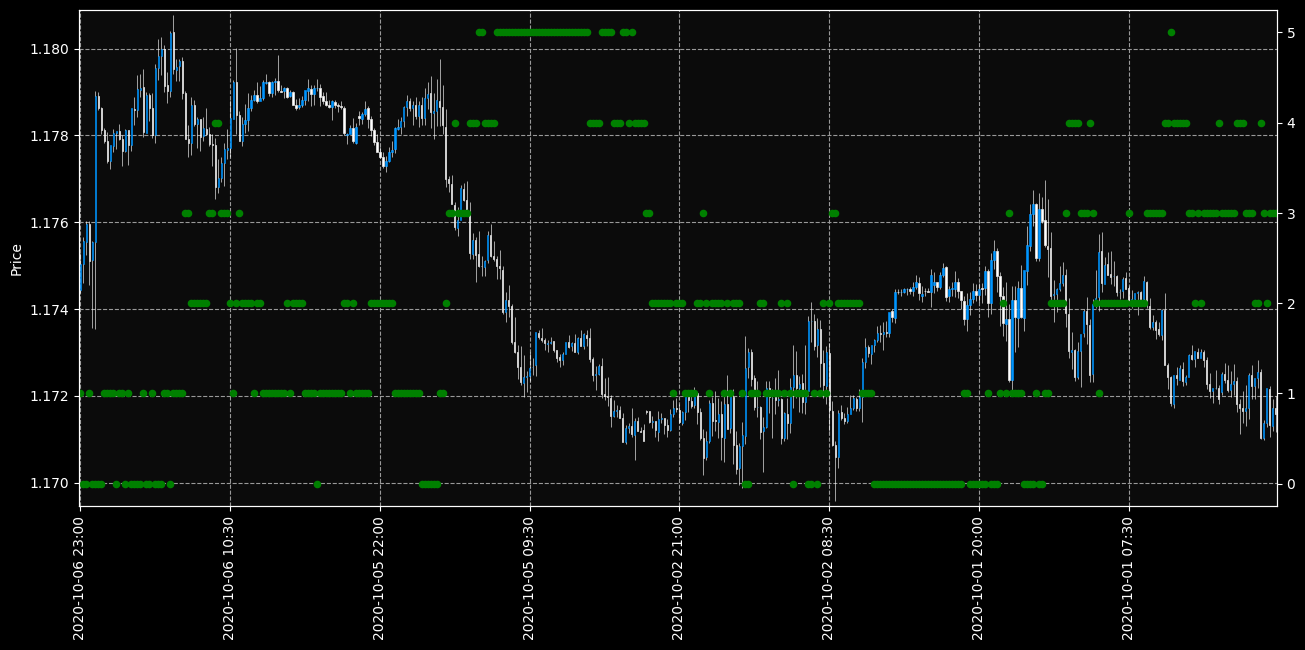

In [75]:


if ('train_images' not in globals() or
    'train_raw' not in globals() or
        'train_labels' not in globals()):
    dict_data = load('train_data.npz')
    train_images = dict_data['images']
    train_raw = dict_data['raw']
    train_labels = dict_data['labels']



df = pd.DataFrame(data={'time': train_raw[0], 'open': train_raw[1], 'high': train_raw[2], 'low': train_raw[3],
                        'close': train_raw[4], 'label0': train_labels[7]+train_labels[8]+train_labels[9]+train_labels[10]+train_labels[11]})
# df = df[::-1].reset_index()


p = df[:400]
p['Time'] = pd.to_datetime(p['time'], unit='s')
p = p.set_index('Time')


# p = df
apds = [
    mpf.make_addplot(p['label0'], type='scatter', markersize=20, color='green', secondary_y=True),
    # mpf.make_addplot(p['label_up'], type='scatter', markersize=10, color='green', secondary_y=True),
    # mpf.make_addplot(p['label_down'], type='scatter', markersize=10, color='orange', secondary_y=True),
    # mpf.make_addplot(p['p_increase'], type='scatter', markersize=20, color='lime', marker='x', secondary_y=True),
    # mpf.make_addplot(p['p_decrease'], type='scatter', markersize=20, color='red', marker='x', secondary_y=True),
    # mpf.make_addplot(p['sell'], type='scatter',markersize=50, marker='v', color='orange'),
    # mpf.make_addplot(p['buy'], type='scatter', markersize=50, marker='^', color='lime'),
    # mpf.make_addplot(p['buy_tp'], type='scatter', markersize=50, marker='x', color='green'),
    # mpf.make_addplot(p['buy_sl'], type='scatter', markersize=50, marker='x', color='red'),
    # mpf.make_addplot(p['sell_tp'], type='scatter', markersize=50, marker='x', color='green'),
    # mpf.make_addplot(p['sell_sl'], type='scatter', markersize=50, marker='x', color='red'),
]

fig, axes = mpf.plot(p, addplot=apds, figratio=(24, 10), type='candle', style='nightclouds', volume=False,
                     datetime_format='%Y-%m-%d %H:%M', xrotation=90, tight_layout=True, returnfig=True)
axes[0].locator_params(nbins=10, axis='x')
plt.show()


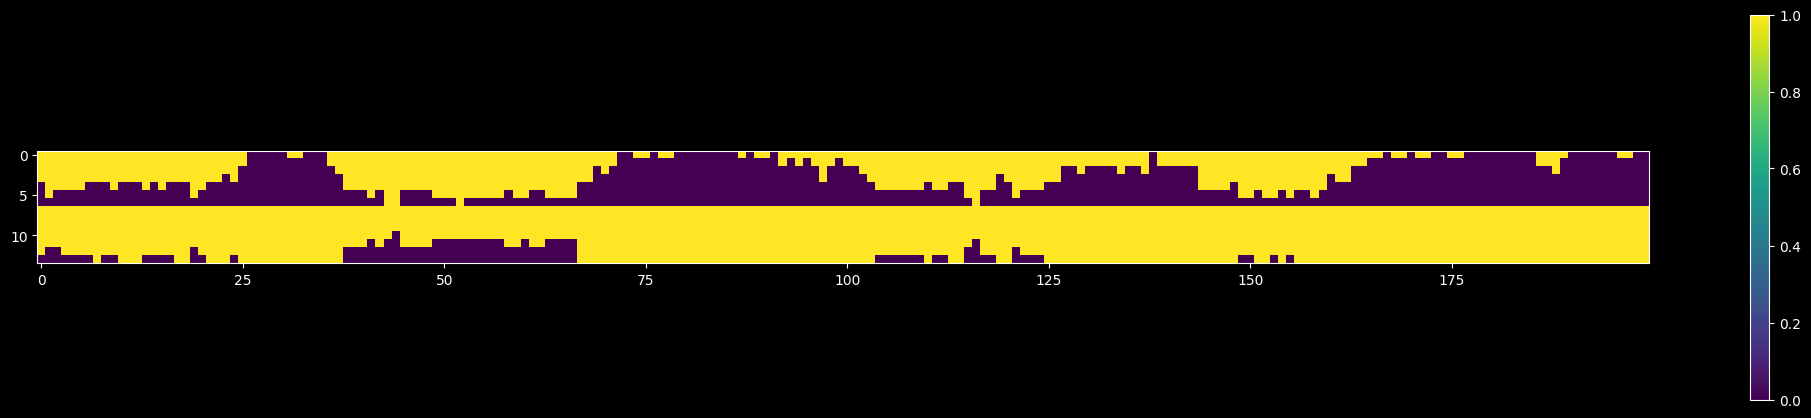

In [34]:
# features_m5[-8,:100]

# a = np.concatenate(([np.interp(i, (i.min(), i.max()), (0, 1)) for i in features_m15[:109,:IMAGE_LENGTH_M15]], features_m15[109:-1,:IMAGE_LENGTH_M15]))
# b = np.concatenate(([np.interp(i, (i.min(), i.max()), (0, 1)) for i in features_h1[:109,:IMAGE_LENGTH_H1]], features_h1[109:-1,:IMAGE_LENGTH_H1]))
# c = np.concatenate(([np.interp(i, (i.min(), i.max()), (0, 1)) for i in features_h4[:109,:IMAGE_LENGTH_H4]], features_h4[109:-1,:IMAGE_LENGTH_H4]))
# d = np.concatenate(([np.interp(i, (i.min(), i.max()), (0, 1)) for i in features_m5[:109,:IMAGE_LENGTH_M5]], features_m5[109:-1,:IMAGE_LENGTH_M5]))
# e = np.concatenate(([np.interp(i, (i.min(), i.max()), (0, 1)) for i in features_d1[:109,:IMAGE_LENGTH_D1]], features_d1[109:-1,:IMAGE_LENGTH_D1]))
# f = np.hstack((a,b,c,d,e))

plt.figure(figsize=(26, 5))
plt.imshow(labels[:,:200])
plt.colorbar()
plt.grid(False)
plt.show()

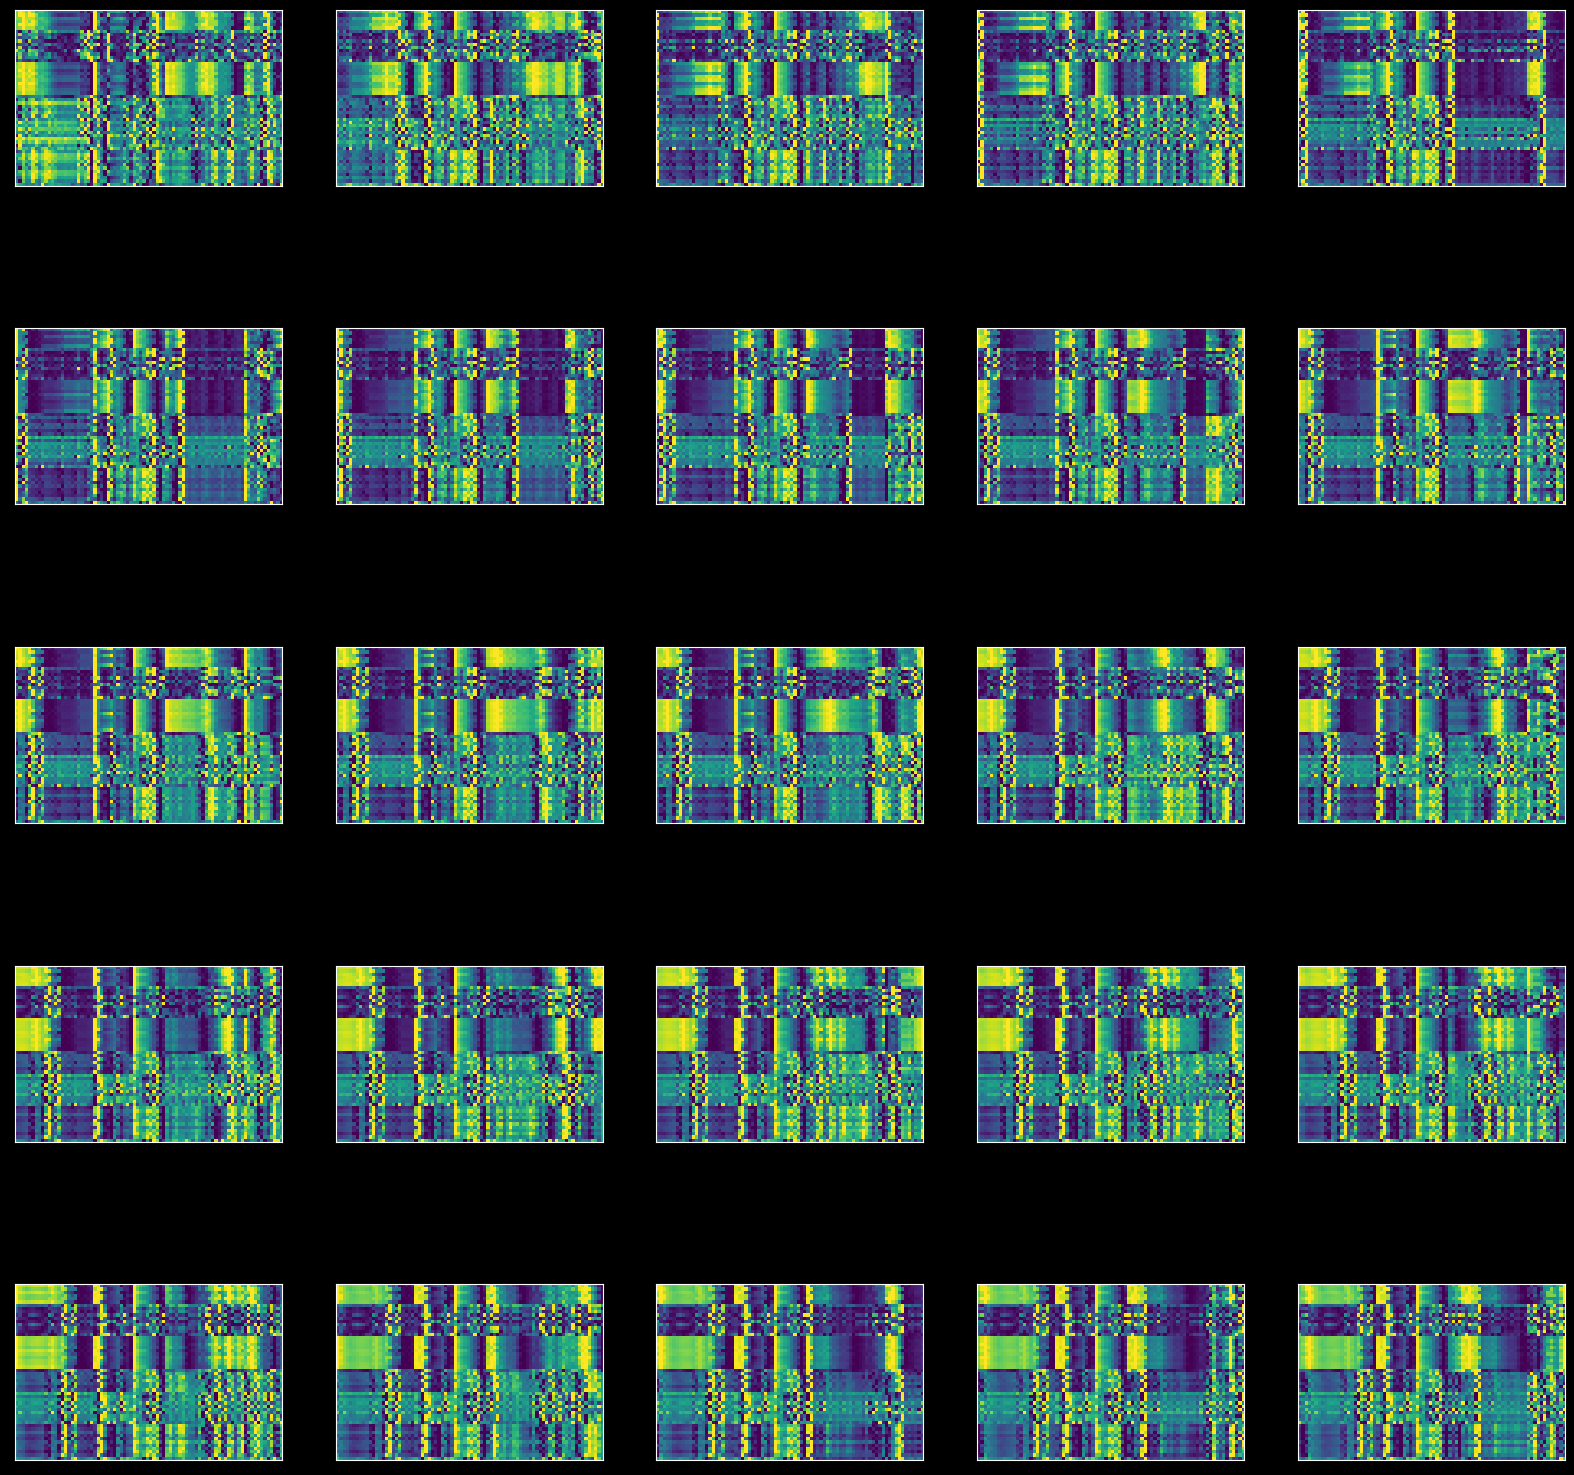

In [35]:
plt.figure(figsize=(20,20))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[-i])
    # plt.xlabel(outs[1,i])
plt.show()

In [36]:

_mof = []

if F_SINGLE_MEDIUM:
    _mof.append('m')
else:
    _mof.append('s')

_mof.append(str(DAY_HISTORY_TO_PROCESS))

if F_VOLUME:
    _mof.append('v1')
else:
    _mof.append('v0')

_mof.append('r' + str(F_REPEAT))

if F_TIME:
    _mof.append('t1')
else:
    _mof.append('t0')

MODELS_FOLDER='models/' + '_'.join(_mof) + '-' + F_LABEL_TIMEFRAME + '_' + str(F_LABEL_PERIOD) + '/'

# MODELS_FOLDER='models/xs_121x151/'

for i in range(0,14):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=(train_images.shape[1], train_images.shape[2])),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10)
    ])
    model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
    model.fit(train_images, train_labels[i], epochs=20)
    model.save(MODELS_FOLDER + 'model_' + str(i))



==========================] - 0s 6ms/step - loss: 0.3778 - accuracy: 0.8392
Epoch 7/20
46/46 [==============================] - 0s 6ms/step - loss: 0.3113 - accuracy: 0.8835
Epoch 8/20
46/46 [==============================] - 0s 6ms/step - loss: 0.2781 - accuracy: 0.8971
Epoch 9/20
46/46 [==============================] - 0s 5ms/step - loss: 0.3249 - accuracy: 0.8692
Epoch 10/20
46/46 [==============================] - 0s 9ms/step - loss: 0.4176 - accuracy: 0.7827
Epoch 11/20
46/46 [==============================] - 0s 5ms/step - loss: 0.2656 - accuracy: 0.8890
Epoch 12/20
46/46 [==============================] - 0s 5ms/step - loss: 0.2649 - accuracy: 0.8971
Epoch 13/20
46/46 [==============================] - 0s 5ms/step - loss: 0.1924 - accuracy: 0.9401
Epoch 14/20
46/46 [==============================] - 0s 6ms/step - loss: 0.2205 - accuracy: 0.9196
Epoch 15/20
46/46 [==============================] - 0s 5ms/step - loss: 0.2448 - accuracy: 0.8971
Epoch 16/20
46/46 [=================

In [ ]:


test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

In [37]:
# predict 0 -> 7

from numpy import load

models = [tf.keras.models.load_model(MODELS_FOLDER + 'model_0'),
        tf.keras.models.load_model(MODELS_FOLDER + 'model_1'),
        tf.keras.models.load_model(MODELS_FOLDER + 'model_2'),
        tf.keras.models.load_model(MODELS_FOLDER + 'model_3'),
        tf.keras.models.load_model(MODELS_FOLDER + 'model_4'),
        tf.keras.models.load_model(MODELS_FOLDER + 'model_5'),
        tf.keras.models.load_model(MODELS_FOLDER + 'model_6'),
        tf.keras.models.load_model(MODELS_FOLDER + 'model_7'),
        tf.keras.models.load_model(MODELS_FOLDER + 'model_8'),
        tf.keras.models.load_model(MODELS_FOLDER + 'model_9'),
        tf.keras.models.load_model(MODELS_FOLDER + 'model_10'),
        tf.keras.models.load_model(MODELS_FOLDER + 'model_11'),
        tf.keras.models.load_model(MODELS_FOLDER + 'model_12'),
        tf.keras.models.load_model(MODELS_FOLDER + 'model_13')]


if ('test_images' not in globals() or
    'test_raw' not in globals() or
        'test_labels' not in globals()):
    dict_data = load('test_data.npz')
    test_images = dict_data['images']
    test_raw = dict_data['raw']
    test_labels = dict_data['labels']

predictions = np.array([np.argmax(models[0].predict(test_images), axis=-1),
                        np.argmax(models[1].predict(test_images), axis=-1),
                        np.argmax(models[2].predict(test_images), axis=-1),
                        np.argmax(models[3].predict(test_images), axis=-1),
                        np.argmax(models[4].predict(test_images), axis=-1),
                        np.argmax(models[5].predict(test_images), axis=-1),
                        np.argmax(models[6].predict(test_images), axis=-1),
                        np.argmax(models[7].predict(test_images), axis=-1),
                        np.argmax(models[8].predict(test_images), axis=-1),
                        np.argmax(models[9].predict(test_images), axis=-1),
                        np.argmax(models[10].predict(test_images), axis=-1),
                        np.argmax(models[11].predict(test_images), axis=-1),
                        np.argmax(models[12].predict(test_images), axis=-1),
                        np.argmax(models[13].predict(test_images), axis=-1)])



from numpy import savez_compressed
savez_compressed('predictions.npz', predictions=predictions)


# R122 Will it drop more than 0.4% Yes no
# R123 Will it drop more than 0.8% Yes no
# R124 Will it drop more than 1.2% Yes no
# R125 Will it drop more than 1.6% Yes no
# R126 Will it drop more than 2.0% Yes no
# R127 Will it drop more than 2.4% Yes no
# R128 Will it drop more than 2.8% Yes no
# R129 Will it increase more than 0.4% Yes no
# R130 Will it increase more than 0.8% Yes no
# R131 Will it increase more than 1.2% Yes no
# R132 Will it increase more than 1.6% Yes no
# R133 Will it increase more than 2.0% Yes no
# R134 Will it increase more than 2.4% Yes no
# R135 Will it increase more than 2.8% Yes no



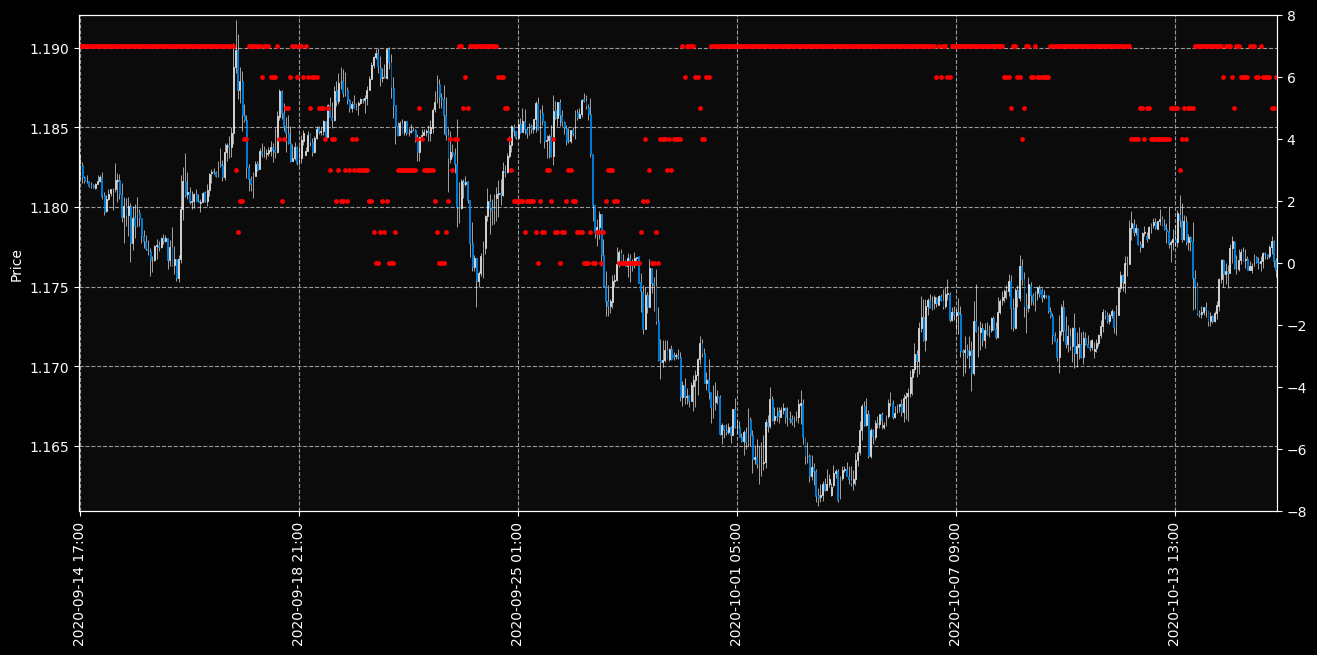

In [8]:


# load dict of arrays
if 'predictions' not in globals():
    dict_data = load('predictions.npz')
    predictions = dict_data['predictions']

if ('test_images' not in globals() or
    'test_raw' not in globals() or
        'test_labels' not in globals()):
    dict_data = load('test_data.npz')
    test_images = dict_data['images']
    test_raw = dict_data['raw']
    test_labels = dict_data['labels']


def _return(d: pd.Series):
    return d.iloc[-1]/d.iloc[0]-1



pred_buy = predictions[7]+predictions[8]+predictions[9]+predictions[10]+predictions[11]+predictions[12]+predictions[13]
# pred_buy = predictions[12]
pred_sell = (predictions[0]+predictions[1]+predictions[2]+predictions[3]+predictions[4]+predictions[5]+predictions[6])

# lb_p_buy = test_labels[12]
lb_p_buy = test_labels[7]+test_labels[8]+test_labels[9]+test_labels[10]+test_labels[11]+test_labels[12]+test_labels[13]
lb_p_sell = (test_labels[0]+test_labels[1]+test_labels[2]+test_labels[3]+test_labels[4]+test_labels[5]+test_labels[6])

p_buy = pred_buy.astype(float)
p_sell = pred_sell.astype(float)

THRESOLD_DIFF = 2
TARGET = 3

buy = (TARGET * LABEL_BASE_RATE + 1) * test_raw[1]
sell = (-2 * LABEL_BASE_RATE + 1) * test_raw[1]

lb_buy = (lb_p_buy * LABEL_BASE_RATE + 1) * test_raw[1]
lb_sell = (-lb_p_sell * LABEL_BASE_RATE + 1) * test_raw[1]

diff_buy = pred_buy - lb_p_buy
diff_buy[diff_buy < 0] = 0
diff_sell = pred_sell - lb_p_sell

# buy_condition = pred_buy == 1
# buy_condition = (pred_buy > pred_sell + THRESOLD_DIFF) & (pred_buy >= TARGET)
buy_condition = (pred_buy > pred_sell + THRESOLD_DIFF) & (pred_buy >= TARGET)

# Buy:
# p_buy > p_sell + THRESOLD_DIFF
# p_buy >= TARGET
# tp: TARGET   | sl: TARGET_SL

buy[buy_condition == False] = np.nan
sell[buy_condition == False] = np.nan



df = pd.DataFrame(data={'time': test_raw[0], 'open': test_raw[1], 'high': test_raw[2], 'low': test_raw[3],
                        'close': test_raw[4], 'sell': sell, 'buy': buy, 'p_sell': -p_sell, 'p_buy': p_buy, 'lb_buy':lb_buy,
                        'lb_sell':lb_sell, 'diff_buy':diff_buy,'diff_sell':diff_sell,'lb_p_buy':lb_p_buy,'pred_buy':pred_buy })
df = df[::-1].reset_index()


# df['pred_buy_ma'] = df['pred_buy'].rolling(48).mean()
# df['lb_p_buy_ma'] = df['lb_p_buy'].rolling(48).mean()
# df['diff_buy_ma'] = df['diff_buy'].rolling(48).mean()


p = df[:]
p['Time'] = pd.to_datetime(p['time'], unit='s')
p = p.set_index('Time')


# p = df
apds = [
    # mpf.make_addplot(p['buy'], type='scatter', markersize=2, color='green', secondary_y=False),
    # mpf.make_addplot(p['sell'], type='scatter', markersize=2, color='yellow', secondary_y=False),
    # mpf.make_addplot(p['lb_buy'], type='scatter', markersize=2, color='red', secondary_y=False),
    # mpf.make_addplot(p['lb_sell'], type='scatter', markersize=2, color='red', secondary_y=False),
    # mpf.make_addplot(p['diff_buy'], type='scatter', markersize=2, color='purple', secondary_y=True),
    # mpf.make_addplot(p['diff_buy_ma'], type='scatter', markersize=2, color='lime', secondary_y=True),
    # mpf.make_addplot(p['p_buy'], type='scatter', markersize=2, color='orange', secondary_y=True),
    # mpf.make_addplot(p['p_sell'], type='scatter', markersize=2, color='green', secondary_y=True),
    # mpf.make_addplot(p['pred_buy_ma'], type='scatter', markersize=2, color='yellow', secondary_y=True),
    # mpf.make_addplot(p['lb_p_buy'], type='scatter', markersize=6, color='red', secondary_y=True),
    # mpf.make_addplot(p['p_sell'], type='scatter', markersize=6, color='red', secondary_y=True),
]

fig, axes = mpf.plot(p, addplot=apds, figratio=(24, 10), type='candle', style='nightclouds', volume=False,
                     datetime_format='%Y-%m-%d %H:%M', xrotation=90, tight_layout=True, returnfig=True)
axes[0].locator_params(nbins=10, axis='x')
axes[1].set_ylim((-8,8))
plt.show()


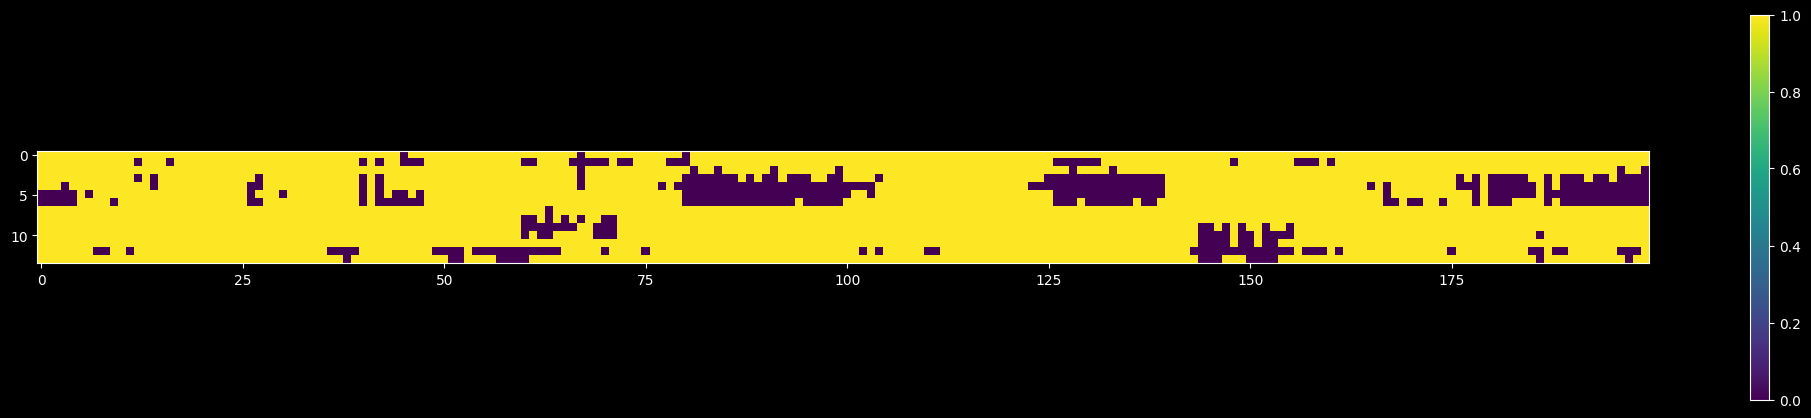

In [39]:
plt.figure(figsize=(26, 5))
plt.imshow(predictions[:,:200])
plt.colorbar()
plt.grid(False)
plt.show()

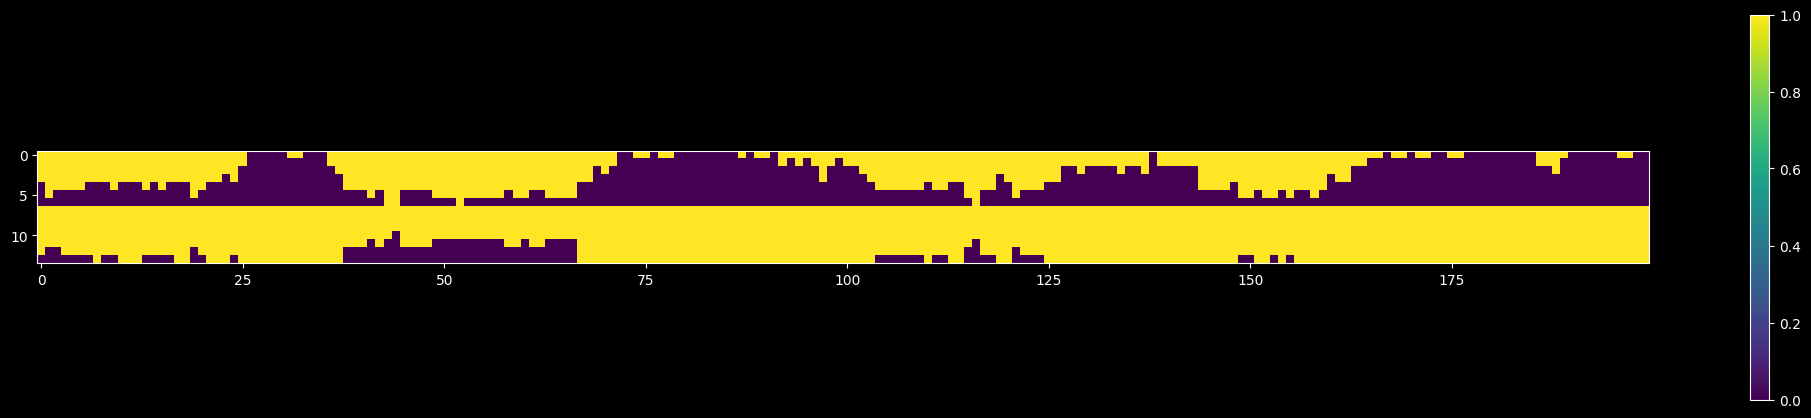

In [40]:
plt.figure(figsize=(26, 5))
plt.imshow(test_labels[:,:200])
plt.colorbar()
plt.grid(False)
plt.show()

In [9]:
diff_buy = pred_buy - lb_p_buy
# diff_buy[diff_buy < 0] = 0
# plt.hist(diff_buy, facecolor='red', alpha=0.5)
# TARGET = 2
TRADE_SIZE = 0.08
TRADE_PROFIT = TRADE_SIZE * 100000 * LABEL_BASE_RATE
FEE = TRADE_SIZE * 7

# for TARGET in range(1,5):
#     for TARGET_SL in range(1,5):
#         for i in range(6):
#             buy_condition = (pred_buy > pred_sell + i) & (pred_buy >= TARGET)
#             buy_pos = (lb_p_buy >= TARGET) & (lb_p_sell < TARGET_SL) & buy_condition
#             buy_neg = ((lb_p_buy < TARGET) | (lb_p_sell >= TARGET_SL)) & buy_condition
#             x = buy_pos.sum()
#             y = buy_neg.sum()
#             print(TARGET, TARGET_SL, i, ':', x, y, x-y, x * TARGET * TRADE_PROFIT - y * TARGET_SL * TRADE_PROFIT - (x + y) * FEE)


# for TARGET in range(1,5):
#     for TARGET_SL in range(1,5):
#         for i in range(6):
#             sell_condition = (pred_sell > pred_buy + i) & (pred_sell >= TARGET)
#             sell_pos = (lb_p_sell >= TARGET) & (lb_p_buy < TARGET_SL) & sell_condition
#             sell_neg = ((lb_p_sell < TARGET) | (lb_p_buy >= TARGET_SL)) & sell_condition
#             x = sell_pos.sum()
#             y = sell_neg.sum()
#             print(TARGET, TARGET_SL, i, ':', x, y, x-y, x * TARGET * TRADE_PROFIT - y * TARGET_SL * TRADE_PROFIT - (x + y) * FEE)

for TARGET in range(1,4):
    for TARGET_SL in range(1,5):
        for i in range(6):
            buy_condition = (pred_buy > pred_sell + i) & (pred_buy >= TARGET)
            buy_pos = (diff_buy <= 0) & (lb_p_sell < TARGET_SL) & buy_condition
            buy_neg = ((diff_buy > 0) | (lb_p_sell >= TARGET_SL)) & buy_condition
            x = buy_pos.sum()
            y = buy_neg.sum()
            pos = pred_buy[buy_pos].sum()
            neg = pred_buy[buy_neg].sum()
            print(TARGET, TARGET_SL, i, ':', pos, neg,x,y, pos * TRADE_PROFIT - y * TARGET_SL * TRADE_PROFIT - (x + y)*FEE)



# for TARGET in range(1,4):
#     for TARGET_SL in range(1,5):
#         for i in range(6):
#             sell_condition = (pred_sell > pred_buy + i) & (pred_sell >= TARGET)
#             sell_pos = (diff_sell <= 0) & (lb_p_buy < TARGET_SL) & sell_condition
#             sell_neg = ((diff_sell > 0) | (lb_p_buy >= TARGET_SL)) & sell_condition
#             x = sell_pos.sum()
#             y = sell_neg.sum()
#             pos = pred_sell[sell_pos].sum()
#             neg = pred_sell[sell_neg].sum()
#             print(TARGET, i, ':', pos, neg,x,y, pos * TRADE_PROFIT - y * TARGET_SL * TRADE_PROFIT - (x + y)*FEE)



# plt.hist2d(diff_buy, pred_buy)
# plt.hist2d(lb_p_buy, pred_buy)
# plt.show()

1 1 0 : 298 1181 43 171 692.9599999999999
1 1 1 : 236 911 34 132 572.64
1 1 2 : 229 660 33 95 785.9200000000001
1 1 3 : 167 438 24 63 616.8799999999999
1 1 4 : 56 161 8 23 193.84
1 1 5 : 14 21 2 3 67.60000000000001
1 2 0 : 448 1031 65 149 840.1600000000002
1 2 1 : 344 803 50 116 623.8399999999997
1 2 2 : 304 585 44 84 798.72
1 2 3 : 222 383 32 55 668.0800000000002
1 2 4 : 77 140 11 20 219.44
1 2 5 : 14 21 2 3 48.400000000000006
1 3 0 : 601 878 87 127 1288.16
1 3 1 : 490 657 71 95 1219.04
1 3 2 : 443 446 64 64 1534.72
1 3 3 : 319 286 46 41 1205.68
1 3 4 : 133 84 19 12 603.44
1 3 5 : 28 7 4 1 157.2
1 4 0 : 661 818 96 118 1089.7600000000004
1 4 1 : 532 615 77 89 1033.44
1 4 2 : 485 404 70 58 1547.5199999999998
1 4 3 : 354 251 51 36 1295.28
1 4 4 : 140 77 20 11 597.04
1 4 5 : 28 7 4 1 150.8
2 1 0 : 298 1181 43 171 692.9599999999999
2 1 1 : 236 911 34 132 572.64
2 1 2 : 229 660 33 95 785.9200000000001
2 1 3 : 167 438 24 63 616.8799999999999
2 1 4 : 56 161 8 23 193.84
2 1 5 : 14 21 2 3 67.60